# Importing Required Libraries
 This section imports all the necessary Python libraries for data processing, machine learning, statistical analysis, and visualization.

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2



# Loading Data
This section reads the dataset files into DataFrames.

Funcmatrices: A CSV file containing functional connectome data.

Labelsdf, metaA, metaB: Excel files containing labels and metadata for participants.

In [2]:
# Since the functional_connectome_matrices is a csv file , we use pd.read_csv
Funcmatrices = pd.read_csv('FUNCTIONAL_CONNECTOME_MATRICES.csv')
#Since the LABELS , METADATA_A , METADATA_B is a xlsx file we use pd.read_excel
Labelsdf = pd.read_excel('LABELS.xlsx')
metaA = pd.read_excel('METADATA_A.xlsx')
metaB = pd.read_excel('METADATA_B.xlsx')

# Inspecting Data Shapes
* Prints the shape (number of rows and columns) of each dataset ription:to give an overview of the data structure.

In [3]:
Funcmatrices.shape

(95, 19901)

In [4]:
metaA.shape


(1213, 19)

In [5]:
metaB.shape


(1213, 10)

In [6]:
Labelsdf.shape

(1213, 3)

# Checking for Missing Values
* This section checks for missing values in the data and prints the number of missing values for each dataset and column.
* Ensures that any missing values are identified before handling them.

In [31]:
print(metaA.isnull().sum().sum())
print(Funcmatrices.isnull().sum().sum())
print(metaB.isnull().sum().sum())

0
0
0


In [32]:
print(Funcmatrices.isnull().sum())


participant_id          0
0throw_1thcolumn        0
0throw_2thcolumn        0
0throw_3thcolumn        0
0throw_4thcolumn        0
                       ..
196throw_198thcolumn    0
196throw_199thcolumn    0
197throw_198thcolumn    0
197throw_199thcolumn    0
198throw_199thcolumn    0
Length: 19901, dtype: int64


# Handling Missing Values
Fills missing values in the datasets.

Numeric Columns: Fill missing numeric data with the mean of the respective column.

Categorical Columns: Fill missing categorical data with the mode (most frequent value) of the respective column.

Details: Handles missing data for Funcmatrices, metaA, and metaB.

In [33]:
# Separate numeric columns
numeric_cols = Funcmatrices.select_dtypes(include=['number']).columns
# Fill NaNs in only numeric columns with their mean
Funcmatrices[numeric_cols] = Funcmatrices[numeric_cols].fillna(Funcmatrices[numeric_cols].mean())




In [34]:
for col in metaA.columns:
    if metaA[col].dtype in ['float64', 'int64']:
        metaA.fillna(metaA[col].mean(), inplace=True)
    else:
        metaA.fillna(metaA[col].mode()[0], inplace=True)

In [35]:
#  Fill missing values in Metadata B (previously missing!) ===
for col in metaB.columns:
    if metaB[col].dtype in ['float64', 'int64']:
        metaB.fillna(metaB[col].mean(), inplace=True)
    else:
        metaB.fillna(metaB[col].mode()[0], inplace=True)

# Merging Datasets
Merges all datasets (metaA, metaB, Funcmatrices, and Labelsdf) based on the participant_id.
 Ensures that all necessary data is combined into a single DataFrame for further processing.

In [36]:
merged = metaA.merge(metaB , on = 'participant_id' , how = 'inner')
merged = merged.merge(Funcmatrices , on = 'participant_id' , how = 'inner')
merged = merged.merge(Labelsdf , on = 'participant_id' , how = 'inner')
merged.head()


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
0,DgRP31gu21O9,94.47,14,3,14,27,18,20,21,0,...,0.050327,-0.043337,0.117421,0.088176,-0.086054,0.135878,0.026985,0.127913,1,0
1,dUPJ6W25gKWI,100.00,14,3,8,35,13,17,20,2,...,-0.071452,0.016370,0.181463,0.021223,0.106712,0.181086,0.164672,0.101452,1,0
2,h2wSdg7XIBUJ,100.00,13,3,16,37,18,18,23,1,...,0.011317,0.012014,0.189406,0.049233,0.009693,0.105716,0.022859,0.175682,1,1
3,8jjvOdQ5WL1z,93.34,14,6,14,34,22,16,25,7,...,0.000286,-0.024456,0.030799,0.028668,0.164651,0.168047,0.089071,0.235597,1,0
4,VZnIq2hRErI5,100.00,14,5,12,42,18,15,24,1,...,-0.041038,-0.069473,0.155428,-0.003444,0.016739,-0.009289,0.099093,0.050303,1,0


In [37]:
print('participant_id' in merged.columns)  # should return True


True


In [38]:
merged.drop(columns=['participant_id'], inplace=True)

In [39]:
X = merged.drop(columns=['ADHD_Outcome', 'Sex_F', 'participant_id'], errors='ignore')
y = merged[['ADHD_Outcome', 'Sex_F']]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Checking for the frequency of each categorical feature using Count plot

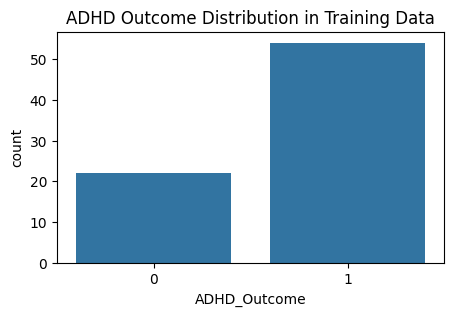

In [41]:
# ADHD Outcome Count Plot
plt.figure(figsize=(5, 3))
sns.countplot(x=y_train["ADHD_Outcome"])
plt.title("ADHD Outcome Distribution in Training Data")
plt.show()

- The above count plot is done to calculate the frequency of each label 0 and 1.
- 0 indicates people with no ADHD
- 1 indicates people with ADHD .
- The number of people with ADHD is significantly higher than the number of people with none or some other nerologcal disease.

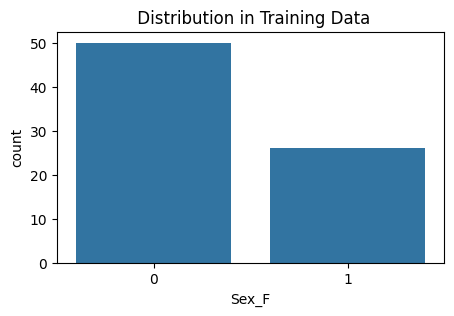

In [18]:
# Sex Count Plot
plt.figure(figsize=(5, 3))
sns.countplot(x=y_train["Sex_F"])
plt.title(" Distribution in Training Data")
plt.show()

- The above count plot is done to calculate the frequency of each label 0 and 1 .
- 0 indicates males.
- 1 indicates females.
- The number of females with ADHD is significantly higher than the number of males with none or some other nerologcal disease.

In [42]:
X_train_c = X_train.columns[27:]
X_train_cdf= X_train[X_train_c]
X_train_cdf

,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
66,0.051145,0.121028,-0.081725,0.061081,0.051842,0.088431,0.047951,0.003648,0.018915,-0.011102,...,-0.044090,0.009518,-0.096676,-0.007233,0.108839,0.067253,0.010531,0.086165,0.065078,0.154482
15,0.065771,0.098714,0.097604,0.112988,0.071139,0.085607,0.019392,-0.036403,-0.020375,0.005426,...,0.066439,-0.076680,-0.047530,-0.031443,0.221213,0.007343,0.005763,0.083820,0.079582,0.067269
78,0.150753,0.054901,0.062244,0.008830,0.058678,0.196030,0.089788,-0.029214,0.027218,-0.000932,...,-0.043093,-0.047271,-0.027638,-0.088943,0.117812,0.030816,0.037119,0.069247,0.170678,0.116697
79,0.024539,0.115689,-0.019450,0.053460,0.111279,0.153638,0.142650,-0.024723,0.021226,-0.084285,...,-0.023250,-0.129260,-0.035315,-0.081737,0.058518,0.098588,0.117367,0.140549,0.130049,0.100255
30,0.055337,0.073712,0.077901,0.051004,0.119618,0.090436,0.028224,0.013527,-0.012790,-0.001450,...,0.049600,0.007778,-0.018346,-0.027651,0.114352,-0.012992,0.090928,0.133553,0.064743,0.078932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.016668,0.075889,-0.010410,0.076217,0.077951,0.112858,0.064658,-0.053502,0.018995,-0.024883,...,-0.048685,-0.022721,0.040425,-0.057429,0.187949,0.122711,0.031954,0.182937,0.165340,0.176245
71,-0.047163,0.194083,0.083379,0.060363,0.051840,0.017147,0.109053,-0.012030,0.024031,-0.029282,...,0.053942,0.021861,0.056240,0.002809,0.035923,0.040852,0.081576,0.129870,0.160253,0.117067
14,0.066947,0.124812,0.055323,0.056200,0.110998,0.136771,0.067829,0.024514,-0.025779,0.017436,...,0.055558,0.023955,0.023600,-0.019650,0.088029,-0.014592,0.089642,0.108644,0.087720,0.031178
92,0.153629,0.074435,0.015124,0.014992,0.034177,0.057369,0.126077,0.093073,-0.056151,0.004281,...,-0.043435,-0.110417,0.077255,-0.076053,0.097439,0.084935,0.065258,0.140520,0.093918,0.082983


In [43]:
def apply_pca(train_df, test_df, columns_to_reduce, variance_threshold=0.90):
    """
    Applies PCA on specified columns of train and test datasets.

    Args:
        train_df (pd.DataFrame): Training dataframe.
        test_df (pd.DataFrame): Testing dataframe.
        columns_to_reduce (list): Columns to apply PCA on.
        variance_threshold (float): Desired variance explained (e.g., 0.95 for 95%).

    Returns:
        merged_train (pd.DataFrame): Train df with PCA components.
        merged_test (pd.DataFrame): Test df with PCA components.
        pca (PCA object): Trained PCA model.
    """
    # Initialize PCA with no component limitation
    pca = PCA()

    # Fit PCA on training data
    pca.fit(train_df[columns_to_reduce])

    # Get cumulative explained variance
    cumulative_variance = pca.explained_variance_ratio_.cumsum()

    # Find the number of components needed to reach the variance threshold
    n_components = (cumulative_variance >= variance_threshold).argmax() + 1

    # Initialize PCA with the determined number of components
    pca = PCA(n_components=n_components)

    # Fit PCA again on the training data
    train_pca = pca.fit_transform(train_df[columns_to_reduce])
    test_pca = pca.transform(test_df[columns_to_reduce])  # ONLY transform test data

    # Create column names for PCA components
    pca_columns = [f'pca_component_{i+1}' for i in range(n_components)]

    # Build new DataFrames from PCA output
    train_pca_df = pd.DataFrame(train_pca, columns=pca_columns, index=train_df.index)
    test_pca_df = pd.DataFrame(test_pca, columns=pca_columns, index=test_df.index)

    # Drop original high-dimensional columns
    train_reduced = train_df.drop(columns=columns_to_reduce, errors='ignore')
    test_reduced = test_df.drop(columns=columns_to_reduce, errors='ignore')

    # Concatenate PCA features back into the remaining data
    merged_train = pd.concat([train_reduced, train_pca_df], axis=1)
    merged_test = pd.concat([test_reduced, test_pca_df], axis=1)

    # Print explained variance
    print(f"Total variance explained by {n_components} PCA components: {pca.explained_variance_ratio_.sum() * 100:.2f}%")

    return merged_train, merged_test, pca

# Apply PCA with automatic component selection based on variance threshold
merged_train, merged_test, pca = apply_pca(X_train, X_test, X_train_c)


Total variance explained by 65 PCA components: 90.01%


In [44]:
metadata_cols = X.columns[:27]

In [45]:
categorical_cols =['Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race','MRI_Track_Scan_Location','Barratt_Barratt_P1_Edu','Barratt_Barratt_P1_Occ','Barratt_Barratt_P2_Edu','Barratt_Barratt_P2_Occ']
numerical_cols = X_train.columns[1:19].tolist()
X_train[categorical_cols] = X_train[categorical_cols].astype('category')
X_train_num = X_train[numerical_cols]
X_train_cat = X_train[categorical_cols]

In [46]:
# Perform chi-square test for each feature with the target
for col in categorical_cols:
    contingency_table = pd.crosstab(X_train_cat[col], y_train['ADHD_Outcome'])  # replace 'target' with your target column name
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square for {col}: p-value = {p_val}")
    if p_val < 0.05:
        print(f"{col} is significantly related to the target-ADHD_OUTCOME.")
    else:
        print("")

Chi-square for Basic_Demos_Study_Site: p-value = 0.11341878260101493

Chi-square for PreInt_Demos_Fam_Child_Ethnicity: p-value = 0.6322601035872211

Chi-square for PreInt_Demos_Fam_Child_Race: p-value = 0.050756170038907734

Chi-square for MRI_Track_Scan_Location: p-value = 0.26875589866082017

Chi-square for Barratt_Barratt_P1_Edu: p-value = 0.4426260014797767

Chi-square for Barratt_Barratt_P1_Occ: p-value = 0.365798245489463

Chi-square for Barratt_Barratt_P2_Edu: p-value = 0.5630961881659151

Chi-square for Barratt_Barratt_P2_Occ: p-value = 0.2480174333675682



In [24]:
# for col in categorical_cols:
#     ct = pd.crosstab(X_train[col].astype(str).fillna("Missing"), y_train['ADHD_Outcome'])
#     if ct.shape[0] > 1 and ct.shape[1] > 1:  # Ensure valid contingency table
#         cv = cramers_v(ct)
#         print(f"Cramér's V for {col}: {cv:.4f}")
#     else:
#         print(f"Skipped {col} due to insufficient unique values.")


Higher Cramér’s V (~ closer to 1) → Stronger association.
Closer to 0 → Weak/no association.

In [47]:
# Create a dictionary of columns and their p-values
chi2_results = {
    'Basic_Demos_Study_Site': 0.026764436349744687,
    'PreInt_Demos_Fam_Child_Ethnicity': 0.1827550181167641,
    'PreInt_Demos_Fam_Child_Race': 0.26089864216788716,
    'MRI_Track_Scan_Location': 3.007189741756566e-05,
    'Barratt_Barratt_P1_Edu': 0.587141220037803,
    'Barratt_Barratt_P1_Occ': 0.7773760650925339,
    'Barratt_Barratt_P2_Edu': 0.8789616160275046,
    'Barratt_Barratt_P2_Occ': 0.9771874313232023
}

# Set the p-value threshold
p_value_threshold = 0.05

# Get a list of columns with significant p-values (less than the threshold)
significant_cols = [col for col, p_val in chi2_results.items()     if p_val < p_value_threshold]

# Print the significant columns
print("Significant columns:", significant_cols)

Significant columns: ['Basic_Demos_Study_Site', 'MRI_Track_Scan_Location']


In [48]:
# Only include numeric columns (int or float), exclude object or category
numerical_cols = merged_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_cols)  # Should not include any strings, IDs, or categorical labels


['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ', 'pca_component_1', 'pca_component_2', 'pca_component_3', 'pca_component_4', 'pca_component_5', 'pca_component_6', 'pca_component_7', 'pca_component_8', 'pca_component_9', 'pca_component_10', 'pca_component_11', 'pca_component_12', 'pca_component_13', 'pca_component_14', 'pca_component_15', 'pca_component_16', 'pca_component_17', 'pca_component_18', 'pca_component_19', 'pca_component_20', 'pca

In [49]:
def drop_highly_correlated(df, threshold=0.8):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f"Dropping {len(to_drop)} highly correlated columns: {to_drop}")
    return df.drop(columns=to_drop), to_drop

# Apply this on numerical part of merged_train
numerical_df = merged_train[numerical_cols]
numerical_df_reduced, dropped_cols = drop_highly_correlated(numerical_df, threshold=0.8)

# You can update merged_train to use the reduced numerical features
merged_train_updated = merged_train.drop(columns=dropped_cols)
merged_test_updated = merged_test.drop(columns=dropped_cols, errors='ignore')  # Safe for test too

print(f"Original number of numerical columns: {numerical_df.shape[1]}")
print(f"Remaining number of numerical columns after dropping: {numerical_df_reduced.shape[1]}")



Dropping 4 highly correlated columns: ['SDQ_SDQ_Externalizing', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems']
Original number of numerical columns: 90
Remaining number of numerical columns after dropping: 86


#### DISPLAYING CORRELATION BETWEEN FEATURES USING HEATMAP


In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap (All Features)")
plt.show()



- The heatmap is a plotting technique to display the correlation values that we previously calculated .
- The diagonals are red as each feature is highly correlated to itself .
- The color of the map explains the correlation . Darker the color more correlated the columns are .

In [29]:
from sklearn.feature_selection import VarianceThreshold

# Assume numerical_df_reduced is your dataframe after correlation-based dropping
selector = VarianceThreshold(threshold=0.01)  # You can tweak this threshold
reduced_data = selector.fit_transform(numerical_df_reduced)

# Get column names that were kept
kept_columns = numerical_df_reduced.columns[selector.get_support()]
reduced_df = pd.DataFrame(reduced_data, columns=kept_columns, index=numerical_df_reduced.index)

print(f"Remaining columns after variance thresholding: {reduced_df.shape[1]}")


Remaining columns after variance thresholding: 86


In [30]:

# Step 1: Extract the categorical columns you want to keep from the original metadata
categorical_cols_to_keep = ['Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity']  # Example columns you want to keep

# Extract categorical data from the original metadata
categorical_train = X_train[categorical_cols_to_keep]
categorical_test = X_test[categorical_cols_to_keep]

# Combine the training and testing dataframes
final_train = pd.concat([merged_train_updated, categorical_train], axis=1)
final_test = pd.concat([merged_test_updated, categorical_test], axis=1)

# Print the shape of each dataset to confirm they are correctly combined
print("Training Data Shape: ", final_train.shape)
print("Testing Data Shape: ", final_test.shape)

# Merge target columns with the features
train_full = pd.concat([merged_train_updated.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
test_full = pd.concat([merged_test_updated.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

train_full.to_csv('final_train.csv', index=False)
test_full.to_csv('final_test.csv', index=False)



Training Data Shape:  (76, 90)
Testing Data Shape:  (19, 90)
